### Introduction

**Our goal is to develop a predictive model using ARIMA to forecast future temperature trends.**

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA

In [4]:
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")
df.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


### Data Cleaning

The dataset I am using contains temperature readings for Denmark over a period of time.

In [5]:
#remove null values
df = df.dropna()
df_denmark = df[df.Country == "Denmark"]
df_denmark.index = pd.to_datetime(df_denmark.dt)
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [6]:
df_denmark = df_denmark.drop(['dt','AverageTemperatureUncertainty'],axis=1)
df_denmark.describe()

,AverageTemperature
count,12664.000000
mean,7.802640
std,6.648288
min,-7.816000
25%,2.084000
50%,7.200000
75%,14.190500
max,21.437000


In [7]:
ts = df_denmark["AverageTemperature"]
ts

dt
1743-11-01     6.068
1744-04-01     5.788
1744-05-01    10.644
1744-06-01    14.051
1744-07-01    16.082
               ...  
2013-04-01     6.026
2013-05-01    12.774
2013-06-01    15.685
2013-07-01    18.735
2013-08-01    18.067
Name: AverageTemperature, Length: 12664, dtype: float64

#### Visualise the data

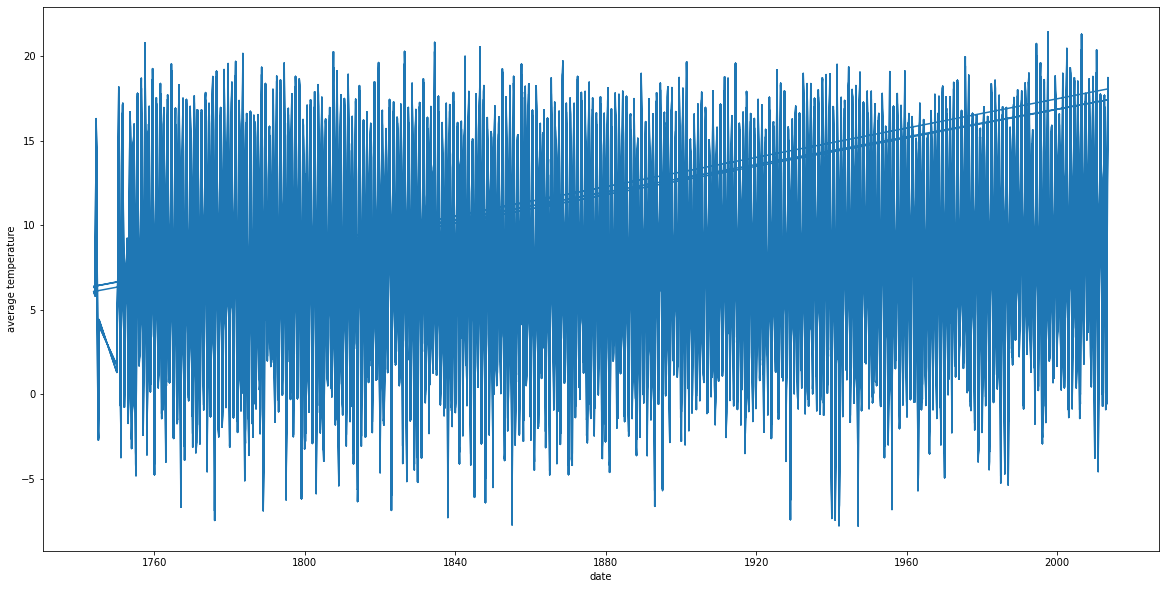

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
fig = plt.figure(1)
ax1 = fig.add_subplot(111) # 111: no of rows, cols, index
ax1.set_xlabel("date")
ax1.set_ylabel("average temperature")
ax1.plot(ts)

### The ADF (Augmented Dickey-Fuller) test for stationarity

The null hypothesis of the test is that the time series data is non-stationary.
If p-value < 5%, we reject the null hypothesis

**As we can see in the visualisation, we cannot identify a trend or seasonal component. Our next step is to check if data is stationary.**

#### Stationarity:
1. Mean is constant
2. Standard deviation is constant
3. No seasonality (ie. No predictable, periodic behavior over time)

#### White noise
1. Mean is 0
2. Standard deviation is constant
3. No seasonality 

### How to check for stationarity?
1. Visually
2. Global vs local tests 
3. ADF test


### Making a TS stationary
suppose y<sub>t</sub> = B<sub>o</sub> + B<sub>1</sub>t + e<sub>t</sub>
(e: error/white noise)

create Z<sub>t</sub> = Y<sub>t</sub> - Y<sub>t-1</sub>
                     = B<sub>1</sub> + (e<sub>t</sub>-e<sub>t-1</sub>)
                     
E(Z<sub>t</sub>)  = B<sub>1</sub> ie. constant
V(Z<sub>t</sub>)  = K<sup>2</sup> ie. constant
                     

In [9]:

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts, autolag='AIC')
print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')

for percentage,value in adf_result[4].items():
    print("Critical Value:")
    print(f'{percentage}{value}')

ADF Statistic:-14.764430391800603
p-value:2.3746970456360347e-27
Critical Value:
1%-3.430868192869495
Critical Value:
5%-2.86176901566292
Critical Value:
10%-2.566891900059256


**Since p-value is much smaller than 5% , we reject the null hypothesis. Hence, time series data is stationary**

### Autoregressive Moving Average (ARMA) Model

In [10]:
from statsmodels.tsa.arima.model import ARIMA

newmodel = ARIMA(ts, order =(1,0,1)) 
#order: (p,d,q) = autoregressive (p), differencing (d), moving average (q) 

results = newmodel.fit()
predictions = results.predict(start = '01/01/1990',end = '01/01/1991')

/Users/sivani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sivani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sivani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sivani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_d

### Model Evaluation

In [11]:
#to check accuracy of our ARIMA model, keeping actual values aside

actuals = df_denmark['01/01/1990':'01/01/1991']['AverageTemperature'][0:13]

In [10]:
# Mean Absolute error: calculates the avg absolute diff between prediction and actuals

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actuals[0:13],predictions)
print(f'MAE:{mae}')

MAE:1.8128749894733902


### Model Tuning

In [11]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

# parameter ranges
p = range(0, 4)
d = 0 #ARMA model
q = range(0, 4)

# all possible combinations of p and q
pq = itertools.product(p, q)

best_aic = float('inf') 
best_order = None

for order in pq:
    try:
        model = ARIMA(ts, order=(*order, d))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
        print(f'ARMA{order} - AIC: {aic:.2f}')
    except:
        continue

print(f'Best ARMA model: ARMA{best_order} - AIC: {best_aic:.2f}')


ARMA(0, 0) - AIC: 83922.21
ARMA(0, 1) - AIC: 70122.31
ARMA(0, 2) - AIC: 68488.96
ARMA(0, 3) - AIC: 80029.43
ARMA(1, 0) - AIC: 69020.31
ARMA(1, 1) - AIC: 65352.36
ARMA(1, 2) - AIC: 67709.81
ARMA(1, 3) - AIC: 72805.67
ARMA(2, 0) - AIC: 60366.31
ARMA(2, 1) - AIC: 65341.60
ARMA(2, 2) - AIC: 67588.46
ARMA(2, 3) - AIC: 70838.02
ARMA(3, 0) - AIC: 56175.95
ARMA(3, 1) - AIC: 63929.43
ARMA(3, 2) - AIC: 67540.54
ARMA(3, 3) - AIC: 70648.53
Best ARMA model: ARMA(3, 0) - AIC: 56175.95


After grid search for ARIMA model parameters, we see that the mean absolute error decreases from 1.8 to 1.3

In [16]:
# EXPERIMENT MANAGER VERSION

import warnings
from statsmodels.tsa.arima.model import ARIMA

import sys
sys.path.append('../decorators')
from expt_mgr import experiment_entry

warnings.filterwarnings('ignore')

# parameter ranges
p = range(0, 4)
d = [0] # ARMA model
q = range(0, 4)

@experiment_entry(p=p, q=q, d=d)
def search_model_params(p, q, d):
    try:
        model = ARIMA(ts, order=(p, q, d))
        results = model.fit()
        aic = results.aic
        return aic
    except:
        print("exception")

search_model_params()

,p,q,d,Model Output
Experiment 1,0.0,0.0,0.0,83922.211326
Experiment 2,0.0,1.0,0.0,70122.312617
Experiment 3,0.0,2.0,0.0,68488.958225
Experiment 4,0.0,3.0,0.0,80029.430986
Experiment 5,1.0,0.0,0.0,69020.311757
Experiment 6,1.0,1.0,0.0,65352.363434
Experiment 7,1.0,2.0,0.0,67709.805631
Experiment 8,1.0,3.0,0.0,72805.668405
Experiment 9,2.0,0.0,0.0,60366.309103
Experiment 10,2.0,1.0,0.0,65341.596543


In [12]:
newmodel = ARIMA(ts, order =(3,0,0)) 
#order: (p,d,q) = autoregressive (p), differencing (d), moving average (q) 

results = newmodel.fit()
predictions = results.predict(start = '01/01/1990',end = '01/01/1991')

In [13]:
predictions = results.predict(start = '01/01/1990',end = '01/01/1991')
mae = mean_absolute_error(actuals[0:13],predictions)
print(f'MAE:{mae}')

MAE:1.5643548323756054


> Thank you for reading my notebook! I hope you found it helpful in some way.
> 
> If you did, please consider upvoting it. If you have any suggestions or improvements, please leave a comment and let me know. Your feedback is greatly appreciated!